# Tutorial 2 - Build a Coupled Natural Human System

Assuming that you have gone through Tutorial 1, Tutorial 2 will focus on how to add human layer into the system. Namely, we will couple an agent-based model (ABM) with a semi-distributed model.

We adopt the Tualatin River Basin (TRB; Figure 1; Table 1) as the tutorial example. The corresponding subbasins' information is shown in Table 1. In this example, we consider three human components (Table 2), including (1) a reservoir (`ResAgt`), (2) an irrigation diversion (`DivAgt`), and (3) a trans-basin water transfer (`PipeAgt`), to demonstrate HydroCNHS's functionalities. Additionally, we model each human agent with different levels of behavioral complexity to provide users with a sense of how an agent can be modeled (Table 2). We will calibrate the model using the streamflow at DLLO and WSLO, reservoir releases from `ResAgt`, and water diversions from `DivAgt` on a monthly scale. More details about TRB can be found in *Lin et al. (2022)*. Here, we focus on the coding part.

<img src="./NB_Figs/TRB_node_link.png" alt="TRB_node_link" width="400"/>

*Figure 1. The node-link structure of the Tualatin River Basin with human components.*


*Table 1. Subbasins’ information for the Tualatin River Basin.*

| Subbasin/outlet | Drainage area [ha] | Latitude [deg] | Flow length [m] |
|-----------------|-------------------:|---------------:|----------------:|
| HaggIn          |         10034.2408 |        45.469  |        0 (to HaggIn) |
| TRTR            |           329.8013 |        45.458  |    30899.4048 (to DLLO) |
| ResAgt\*        |                –   |             –  |    9656.064 (to DLLO) |
| DLLO            |         22238.4391 |        45.475  |  11748.211 (to TRGC) |
| TRGC            |         24044.6363 |        45.502  |        0 (to TRGC) |
| DAIRY           |         59822.7546 |        45.520  |  70988.164 (to WSLO) |
| RCTV            |         19682.6046 |        45.502  |  60398.680 (to WSLO) |
| WSLO            |         47646.8477 |        45.350  |        0 (to WSLO) |

\*ResAgt is a reservoir agent integrated with Dam API. It is considered a pseudo routing outlet.


*Table 2. Summary of human components’ setting.*

| Item                        | Agent name | API             | Behavioral design                       | From   |
|-----------------------------|------------|-----------------|-----------------------------------------|--------|
| Reservoir                   | ResAgt     | Dam API         | Fixed operational rules                 | HaggIn |
| Irrigation diversion        | DivAgt     | RiverDiv API    | Calibrated adaptive behavioral rules    | TRGC   |
| Trans-basin water transfer   | PipeAgt    | Conveying API   | External input data                     | –      |



## Step 1: Create a model configuration file (`model.yaml`)

Creating a node-link structure of a modeled water system is a vital step before using HydroCNHS. Subbasin outlets are determined based on the major tributaries in the TRB. However, the subbasin outlet, TRTR, is predefined because there is an inlet for trans-basin water transfer. For the routing outlet assignment, DLLO and WSLO are selected because the streamflow at these locations is part of the calibration targets. TRGC is also chosen since an agent integrated using the RiverDiv API can only divert water from a routing outlet. HaggIn is picked because it is the inflow for ResAgt (i.e., ResAgt takes water from HaggIn).

With a node-link structure of the TRB water system, we can follow the same process shown in Tutorial 1 to initialize a model builder, set up the water system with the simulation period, add subbasins, and add four routing outlets. Note that ResAgt is considered a pseudo-routing outlet that needs to be assigned to one of the upstream outlets of a routing outlet.


In [1]:
import os
import hydrocnhs

# Set the working directory
wd = os.path.abspath(
    os.path.join(
        os.path.dirname(hydrocnhs.__file__),
        '..', 'tutorials',
        'Tutorial_2-Build_a_Coupled_Natural_Human_System'
        )
    )

# Initialize a model builder object.
mb = hydrocnhs.ModelBuilder(wd)

# Setup a water system simulation information
mb.set_water_system(start_date="1981/1/1", end_date="2013/12/31")

# Setup land surface model (i.e., rainfall-runoff model)
# Here we have seven subbasins and we select GWLF as the rainfall-runoff model.
outlet_list = ['HaggIn', 'TRTR', 'DLLO', 'TRGC', 'DAIRY', 'RCTV', 'WSLO']
area_list = [10034.2408, 329.8013, 22238.4391, 24044.6363, 59822.7546,
            19682.6046, 47646.8477]
lat_list = [45.469, 45.458, 45.475, 45.502, 45.520, 45.502, 45.350]
mb.set_rainfall_runoff(outlet_list=outlet_list,area_list=area_list,
                    lat_list=lat_list, runoff_model="GWLF")

# Setup routing outlets
# Add WSLO
mb.set_routing_outlet(routing_outlet="WSLO",
                    upstream_outlet_list=["TRGC", "DAIRY", "RCTV", "WSLO"],
                    flow_length_list=[80064.864, 70988.164, 60398.680, 0])
# Add TRGC
mb.set_routing_outlet(routing_outlet="TRGC",
                    upstream_outlet_list=["DLLO", "TRGC"],
                    flow_length_list=[11748.211, 0])
# Add DLLO
# Specify that ResAgt is an instream object.
mb.set_routing_outlet(routing_outlet="DLLO",
                    upstream_outlet_list=["ResAgt", "TRTR", "DLLO"],
                    flow_length_list=[9656.064, 30899.4048, 0],
                    instream_objects=["ResAgt"])
# Add HaggIn
mb.set_routing_outlet(routing_outlet="HaggIn",
                    upstream_outlet_list=["HaggIn"],
                    flow_length_list=[0])

Follow the following steps to create model & ABM script templates:
	Step 1: set_water_system()
	Step 2: set_rainfall_runoff()
	Step 3: set_routing_outlet(), one at a time.
	Step 4: (optional) set_sediment().
	Step 5: (optional) add_sediment(), one at a time.
	Step 6: (optional) set_ABM().
	Step 7: (optional) add_agent().
	Step 8: (optional) add_institution().
	Step 9: write_model_to_yaml()
	Step 10: (optional) gen_ABM_script_template()
Open the generated draft 'model.yaml' (& ABM module template) and further edit them.
Use .help to re-print the above instructions.


### Initialize ABM setting

To add human components, we first need to initialize the ABM setting block by assigning the directory of an ABM module folder and the planned ABM module filename. If these are not provided, default values will be applied, namely the working directory and "ABM_module.py," respectively. The `abm_module_name` will be used as the filename for the ABM module template if users choose to generate one using the model builder.


In [2]:
mb.set_ABM(abm_module_folder_path=wd, abm_module_name="TRB_ABM.py")

Next, we add human components (i.e., agents) to the model builder. We first add a reservoir agent (`ResAgt`), where its corresponding agent type class, agent name, API, link dictionary, and decision-making class can be assigned at this stage. Although not all information has to be provided now (i.e., it can be manually added to the `model.yaml` file later), we encourage users to provide complete details here.


In [3]:
mb.add_agent(
    agt_type_class="Reservoir_AgtType", agt_name="ResAgt",
    api=mb.api.Dam,
    link_dict={"HaggIn": -1, "ResAgt": 1},
    dm_class="ReleaseDM"
    )

The setting shown above means that `ResAgt` (an agent object) will be created from `Reservoir_AgtType` (an agent type class) and integrated into HydroCNHS using the Dam API. A decision-making object will be created from `ReleaseDM` (a decision-making class) and assigned to `ResAgt` as its attribute. This agent, `ResAgt`, will take water (factor = -1) from the `HaggIn` routing outlet and release (factor = 1) water to `ResAgt`. Remember that `ResAgt` itself is a pseudo-routing outlet.

Following a similar procedure, we add a water diversion agent (`DivAgt`). However, we have parameters, including `ReturnFactor`, `a`, and `b`, involved in this agent. Hence, a dictionary is provided to the `par_dict` argument. The format of the parameter dictionary is that keys are parameter names, and values are parameter values (-99 means waiting to be calibrated).

However, if the parameter is the factor used in the `link_dict`, users need to follow the format shown here. For example, if we want to calibrate a return factor (`ReturnFactor`) to determine the portion of diverted water returned to the `WSLO` subbasin, we provide a list, `["ReturnFactor", 0, "Plus"]`, to the `link_dict` at `WSLO`. HydroCNHS will interpret it as taking the factor value from the parameter `ReturnFactor` with a list index of 0. "Plus" tells HydroCNHS to add water to `WSLO`. If water is taken from `WSLO`, then "Minus" should be assigned.

Note: `-99` is a default value indicating that this parameter is subject to calibration.

In [4]:
mb.add_agent(
    agt_type_class="Diversion_AgType", agt_name="DivAgt",
    api=mb.api.RiverDiv,
    link_dict={"TRGC": -1, "WSLO": ["ReturnFactor", 0, "Plus"]},
    dm_class="DivertDM",
    par_dict={"ReturnFactor": [-99], "a": -99, "b":-99}
    )

Finally, we add a trans-basin water transfer agent (`PipeAgt`).

In [5]:
mb.add_agent(
    agt_type_class="Pipe_AgType", agt_name="PipeAgt",
    api=mb.api.Conveying,
    link_dict={"TRTR": 1},
    dm_class="TransferDM"
    )

### Add institution

We did not include an institution in this TRB example; however, if users want to assign an institution (e.g., “ResDivInstitution”) to `ResAgt` and `DivAgt`, they should do so by assuming that there is cooperation between water release decisions and water diversion decisions. Namely, release decisions from `ResAgt` and diversion decisions from `DivAgt` are made simultaneously using a single decision-making object (Figure 2). Users can do the following.

Note: `ResDivInstitution` will overwrite the originally assigned decision-making (DM) classes (if any) of `ResAgt` and `DivAgt`. The above command means that a single `ResDivInstitution` decision-making object, initialized from `ResDivDMClass`, will be assigned to the attributes (e.g., `self.dm`) of `ResAgt` and `DivAgt`. Users can utilize this property to design their agents.


In [6]:
# Do not run this cell for this tutorial
"""
mb.add_institution(
    institution="ResDivInstitution",
    instit_dm_class=" ResDivDMClass",
    agent_list=[" ResAgt ", "DivAgt"]
    )
"""

'\nmb.add_institution(\n    institution="ResDivInstitution",\n    instit_dm_class=" ResDivDMClass",\n    agent_list=[" ResAgt ", "DivAgt"]\n    )\n'

### Generate `ABM module template` & output `model.yaml`

In addition to outputting a model configuration file (`.yaml`), the model builder can generate an ABM module template (`.py`) for users. In this template, the model builder will create the outline of agent type classes and decision-making classes, allowing users to focus on programming the calculations for each class provided in the template.


In [7]:
# Output draft model configuration file (i.e., model.yaml) and ABM module template (i.e., TRB_ABM.py).
mb.write_model_to_yaml(filename="model.yaml")
mb.gen_ABM_module_template()

[09/07 03:12:01] HydroCNHS.sc [INFO] Model is saved at C:\Users\CL\Documents\GitHub\HydroCNHS\tutorials\Tutorial_2-Build_a_Coupled_Natural_Human_System\model.yaml.
Model configuration file (.yaml) have been save at C:\Users\CL\Documents\GitHub\HydroCNHS\tutorials\Tutorial_2-Build_a_Coupled_Natural_Human_System\model.yaml. Please open the file and further edit it.
ABM module template (.py) have been save at C:\Users\CL\Documents\GitHub\HydroCNHS\tutorials\Tutorial_2-Build_a_Coupled_Natural_Human_System\TRB_ABM.py. Please open the file and further edit it.


## Step 2: Complete a `model.yaml`

After the model configuration file (`.yaml`) is created, users should open the file to complete and correct any missing or misinterpreted values. For this example, we will again keep the default values.

## Step 3: Program ABM module (.py)**

In the generated ABM module (`.py`), users will find two main types of classes: agent type classes (`AgtType`) and decision-making classes (`DMClass`/`Institutional DMClass`). Agent type classes are used to define agents' actions and store up-to-date information (e.g., current date and current time step) in agents' attributes. Decision-making classes are used to program specific decision-making processes. These decision-making classes can be further divided into `DMClass` and `Institutional DMClass`.

The ABM design logic is illustrated in Figure 2. A "class" is a template for objects that can be instantiated with object-specific attributes and settings. For example, `Agent1` and `Agent2` are instantiated from the same `AgtType1` class. `Agent2`, `Agent4`, and `Agent5` are instantiated from the `AgtType2` class. Each agent will be assigned a DM object or Institution object as one of its attributes. DM objects instantiated from `DMClass` are not shared with other agents; namely, agents with DM objects will each have a unique DM object (e.g., `Agent1` and `Agent2` in Fig. 6). In contrast, an Institution object can be shared with multiple agents, allowing those agents to make decisions together. For example, multiple irrigation districts might make diversion decisions together to share the water shortage during a drought period. We will not implement the `Institutional DMClass` in this TRB example; however, we will show how to add an institution through the model builder.

<img src="./NB_Figs/ABM_design_logic.png" alt="ABM_design_logic." width="650"/>

*Figure 2. ABM Design Logic. An agent is a combination of an `AgtType` class and a `(Institutional) DM` class. An Institution object can be shared among a group of agent objects (i.e., making decisions together), while a DM object can only be assigned to one agent object.*



### Agent Type Class (`AgtType`):

- `self.name`: agent’s name
- `self.config`: agent’s configuration dictionary, `{‘Attributes’: …, ‘Inputs’: …, ‘Pars’: …}`
- `self.start_date`: start date (`datetime` object)
- `self.current_date`: current date (`datetime` object)
- `self.data_length`: data/simulation length
- `self.t`: current timestep
- `self.dc`: data collector object containing data. Routed streamflow (`Q_routed`) is also collected here.
- `self.rn_gen`: NumPy random number generator
- `self.agents`: a dictionary of all initialized agents, `{agt_name: agt object}`
- `self.dm`: (Institutional) decision-making object if `DMClass` or institution is assigned to the agent, otherwise `None`


In [8]:
from hydrocnhs.abm import Base, read_factor

# AgtType
class XXX_AgtType(Base):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The AgtType inherited attributes are applied.
        # See the note at top.

    def act(self, outlet):
        # Read corresponding factor of the given outlet
        factor = read_factor(self.config, outlet)

        # Common usage:
        # Get streamflow of outlet at timestep t
        Q = self.dc.Q_routed[outlet][self.t]

        # Make decision from (Institutional) decision-making
        # object if self.dm is not None.
        #decision = self.dm.make_dm(your_arguments)

        if factor <= 0:     # Divert from the outlet
            action = 0
        elif factor > 0:    # Add to the outlet
            action = 0

        return action

### (Institutional) decision-making classes (`DMClass`):

- `self.name`: name of the agent or institution
- `self.dc`: data collector object containing data. Routed streamflow (`Q_routed`) is also collected here.
- `self.rn_gen`: NumPy random number generator


In [9]:
# DMClass
class XXX_DM(Base):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The (Institutional) DMClass inherited attributes are applied.
        # See the note at top.

    def make_dm(self, your_arguments):
        # Decision-making calculation.
        decision = None
        return decision

To keep the manual concise, we provide a complete ABM module for the TRB example at `./tutorials/Tutorial_2-Build_a_Coupled_Natural_Human_System/TRB_ABM_complete.py`. Formulation details can be found in *Lin et al. (2022)*, and more coding tips are available in the "Advanced ABM Coding Tips" section in the manual.


## Step 4: Run a calibration

First, we load `model.yaml`, the climate data, and the observed monthly flow data for DLLO and WSLO, reservoir releases from `ResAgt`, and water diversions from `DivAgt`. Here, we have calculated the evapotranspiration using the Hamon method, so PET data is input along with other data. 

Note: We manually change the ABM module from `TRB_ABM.py` to `TRB_ABM_complete.py` in `model.yaml` before continuing this tutorial. See the following code.


In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import hydrocnhs.calibration as cali
from copy import deepcopy

# Load climate data
temp = pd.read_csv(
    os.path.join(wd,"Data","Temp_degC.csv"), index_col=["Date"]
    ).to_dict(orient="list")
prec = pd.read_csv(
    os.path.join(wd,"Data","Prec_cm.csv"), index_col=["Date"]
    ).to_dict(orient="list")
pet = pd.read_csv(
    os.path.join(wd,"Data","Pet_cm.csv"), index_col=["Date"]
    ).to_dict(orient="list")

# Load flow gauge monthly data at WSLO
obv_flow_data = pd.read_csv(os.path.join(wd,"Data","Cali_M_cms.csv"),
                            index_col=["Date"], parse_dates=["Date"])

# Load model
model_dict = hydrocnhs.load_model(os.path.join(wd, "model.yaml"))

# Change the ABM module to the complete one.
model_dict["WaterSystem"]["ABM"]["Modules"] = ["TRB_ABM_complete.py"]

[09/07 03:32:23] HydroCNHS.sc [INFO] Parsed model data summary:
SimSeq
  ['HaggIn', 'ResAgt', 'DLLO', 'TRGC', 'WSLO']
RoutingOutlets
  ['HaggIn', 'DLLO', 'TRGC', 'WSLO']
DamAgents
  ['ResAgt']
ConveyingAgents
  ['PipeAgt']
RiverDivAgents
  ['DivAgt']
InsituAgents
  []
AgSimSeq
  AgSimMinus
    HaggIn
      {}
    ResAgt
      {}
    DLLO
      {}
    TRGC
      {'RiverDivAgents': [('DivAgt', 'TRGC')]}
    WSLO
      {}
  AgSimPlus
    HaggIn
      {}
    ResAgt
      {'DamAgents': [('ResAgt', 'ResAgt')]}
    DLLO
      {'ConveyingAgents': [('PipeAgt', 'TRTR')]}
    TRGC
      {}
    WSLO
      {'RiverDivAgents': [('DivAgt', 'WSLO')]}


Second, we generate default parameter bounds and create a converter for calibration. Note that we manually change the default ABM parameter bounds as shown in the code. Details about the converter are provided in the `Calibration` section in the manual.


In [11]:
# Generate default parameter bounds
df_list, df_name = hydrocnhs.write_model_to_df(model_dict)
par_bound_df_list, df_name = hydrocnhs.gen_default_bounds(model_dict)

# Modify the default bounds of ABM
df_abm_bound = par_bound_df_list[2]
df_abm_bound.loc["ReturnFactor.0", [('DivAgt', 'Diversion_AgType')]] = "[0, 0.5]"
df_abm_bound.loc["a", [('DivAgt', 'Diversion_AgType')]] = "[-1, 1]"
df_abm_bound.loc["b", [('DivAgt', 'Diversion_AgType')]] = "[-1, 1]"

# Create convertor for calibration
converter = cali.Convertor()
cali_inputs = converter.gen_cali_inputs(wd, df_list, par_bound_df_list)
formatter = converter.formatter

C:\Users\CL\Documents\GitHub\HydroCNHS\hydrocnhs\util.py:266: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[25, 100]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[k, :] = str(v)
C:\Users\CL\Documents\GitHub\HydroCNHS\hydrocnhs\util.py:266: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[25, 100]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[k, :] = str(v)
C:\Users\CL\Documents\GitHub\HydroCNHS\hydrocnhs\util.py:266: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[25, 100]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[k, :] = str(v)
C:\Users\CL\Documents\GitHub\HydroCNHS\hydrocnhs\util.py:266:

Third, we program the evaluation function for a genetic algorithm (GA). The mean Kling-Gupta efficiency (KGE) of the four calibration targets is adopted to represent the model performance.


In [13]:
# Code evaluation function for GA algorthm
def evaluation(individual, info):
    cali_wd, current_generation, ith_individual, formatter, _ = info
    name = "{}-{}".format(current_generation, ith_individual)

    ##### individual -> model
    # Convert 1D array to a list of dataframes.
    df_list = cali.Convertor.to_df_list(individual, formatter)
    # Feed dataframes in df_list to model dictionary.
    model = deepcopy(model_dict)
    for i, df in enumerate(df_list):
        s = df_name[i].split("_")[0]
        model = hydrocnhs.load_df_to_model_dict(model, df, s, "Pars")

    ##### Run simuluation
    model = hydrocnhs.Model(model, name)
    Q = model.run(temp, prec, pet)

    ##### Get simulation data
    # Streamflow of routing outlets.
    cali_target = ["WSLO","DLLO","ResAgt","DivAgt"]
    cali_period = ("1981-1-1", "2005-12-31")
    sim_Q_D = pd.DataFrame(Q, index=model.pd_date_index)[["WSLO","DLLO"]]
    sim_Q_D["ResAgt"] = model.dc.ResAgt["Release"]
    sim_Q_D["DivAgt"] = model.dc.DivAgt["Diversion"]
    # Resample the daily simulation output to monthly outputs.
    sim_Q_M = sim_Q_D[cali_target].resample("MS").mean()

    KGEs = []
    for target in cali_target:
        KGEs.append(hydrocnhs.Indicator().KGE(
            x_obv=obv_flow_data[cali_period[0]:cali_period[1]][[target]],
            y_sim=sim_Q_M[cali_period[0]:cali_period[1]][[target]]))

    fitness = sum(KGEs)/4
    return (fitness,)

Fourth, we set up a GA for calibration. Again, we will explain calibration in more detail in the Calibration section. Here, only the code is demonstrated. Note that calibration might take some time to run, depending on your system specifications. Users can lower the `pop_size` and `max_gen` values if they want to experience the process rather than seeking convergence. To debug your code, set `paral_cores` to 1 to display the error message.


In [20]:
config = {
    'min_or_max': 'max',
    'pop_size': 100,
    'num_ellite': 1,
    'prob_cross': 0.5,
    'prob_mut': 0.15,
    'stochastic': False,
    'max_gen': 100,
    'sampling_method': 'LHC',
    'drop_record': False,
    'paral_cores': -1,
    'paral_verbose': 1,
    'auto_save': True,
    'print_level': 1,
    'plot': True
    }

seed = 5
rn_gen = hydrocnhs.create_rn_gen(seed)
ga = cali.GA_DEAP(evaluation, rn_gen)
ga.set(cali_inputs, config, formatter, name="Cali_HydroABMModel_gwlf_KGE")
ga.run()
summary = ga.summary
individual = ga.solution

GA Calibration Guide
Step 1: set or load (GA_auto_save.pickle).
Step 2: run.
[09/07 03:51:04] HydroCNHS.GA [INFO] User-provided random number generator is assigned.
[09/07 03:51:04] HydroCNHS.GA [WARNING] Current calibration folder exists. Default to overwrite the folder!
C:\Users\CL\Documents\GitHub\HydroCNHS\tutorials\Tutorial_2-Build_a_Coupled_Natural_Human_System\Cali_HydroABMModel_gwlf_KGE


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished



=====Generation 0=====
  Elapsed time 00:01:46
  Min -0.52451
  Max -0.14027
  Avg -0.37339
  Std 0.10851


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.7min finished



=====Generation 1=====
  Elapsed time 00:03:28
  Min -0.39288
  Max -0.1205
  Avg -0.14498
  Std 0.02978


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 2=====
  Elapsed time 00:05:05
  Min -0.23249
  Max -0.05176
  Avg -0.12245
  Std 0.01507


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:  1.8min finished



=====Generation 3=====
  Elapsed time 00:06:52
  Min -0.25591
  Max -0.04635
  Avg -0.06258
  Std 0.03904


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.2min finished



=====Generation 4=====
  Elapsed time 00:08:02
  Min -0.16422
  Max -0.04422
  Avg -0.05199
  Std 0.02204


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:  1.2min finished



=====Generation 5=====
  Elapsed time 00:09:12
  Min -0.25072
  Max -0.02714
  Avg -0.04843
  Std 0.02365


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.2min finished



=====Generation 6=====
  Elapsed time 00:10:24
  Min -0.22317
  Max -0.02569
  Avg -0.03347
  Std 0.0311


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:  1.5min finished



=====Generation 7=====
  Elapsed time 00:11:52
  Min -0.13323
  Max -0.02569
  Avg -0.0273
  Std 0.01161


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:  1.2min finished



=====Generation 8=====
  Elapsed time 00:13:01
  Min -0.20305
  Max -0.01268
  Avg -0.03372
  Std 0.02991


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.2min finished



=====Generation 9=====
  Elapsed time 00:14:13
  Min -0.17004
  Max -0.00923
  Avg -0.01791
  Std 0.02219


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.2min finished



=====Generation 10=====
  Elapsed time 00:15:24
  Min -0.38657
  Max -0.00682
  Avg -0.02046
  Std 0.04735


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:  1.2min finished



=====Generation 11=====
  Elapsed time 00:16:37
  Min -0.26159
  Max -0.00672
  Avg -0.01498
  Std 0.03208


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:  1.2min finished



=====Generation 12=====
  Elapsed time 00:17:49
  Min -0.11581
  Max -0.00637
  Avg -0.01022
  Std 0.01467


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.2min finished



=====Generation 13=====
  Elapsed time 00:19:00
  Min -0.04625
  Max -0.00601
  Avg -0.00703
  Std 0.00431


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:  1.2min finished



=====Generation 14=====
  Elapsed time 00:20:13
  Min -0.38663
  Max -0.00601
  Avg -0.01511
  Std 0.04116


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.2min finished



=====Generation 15=====
  Elapsed time 00:21:26
  Min -0.24554
  Max -0.00601
  Avg -0.01432
  Std 0.03447


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.2min finished



=====Generation 16=====
  Elapsed time 00:22:37
  Min -0.13009
  Max -0.00601
  Avg -0.0073
  Std 0.01235


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.2min finished



=====Generation 17=====
  Elapsed time 00:23:52
  Min -0.22532
  Max -0.00594
  Avg -0.01311
  Std 0.02779


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.2min finished



=====Generation 18=====
  Elapsed time 00:25:03
  Min -0.37389
  Max -0.00594
  Avg -0.0236
  Std 0.05755


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:  1.2min finished



=====Generation 19=====
  Elapsed time 00:26:16
  Min -0.27824
  Max -0.00594
  Avg -0.01517
  Std 0.0372


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.2min finished



=====Generation 20=====
  Elapsed time 00:27:29
  Min -0.21936
  Max -0.00594
  Avg -0.01213
  Std 0.03379


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.2min finished



=====Generation 21=====
  Elapsed time 00:28:41
  Min -0.28508
  Max -0.0036
  Avg -0.01549
  Std 0.04224


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.2min finished



=====Generation 22=====
  Elapsed time 00:29:56
  Min -0.38962
  Max -0.0036
  Avg -0.01927
  Std 0.05778


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.2min finished



=====Generation 23=====
  Elapsed time 00:31:07
  Min -0.34244
  Max -0.00239
  Avg -0.01463
  Std 0.04689


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.2min finished



=====Generation 24=====
  Elapsed time 00:32:21
  Min -0.3446
  Max -0.00166
  Avg -0.01085
  Std 0.0426


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.2min finished



=====Generation 25=====
  Elapsed time 00:33:34
  Min -0.24432
  Max -0.00098
  Avg -0.0105
  Std 0.03533


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.2min finished



=====Generation 26=====
  Elapsed time 00:34:46
  Min -0.20114
  Max -0.00098
  Avg -0.00595
  Std 0.02597


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.3min finished



=====Generation 27=====
  Elapsed time 00:36:03
  Min -0.24446
  Max -0.00098
  Avg -0.00792
  Std 0.03366


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.4min finished



=====Generation 28=====
  Elapsed time 00:37:28
  Min -0.27293
  Max -0.00096
  Avg -0.00979
  Std 0.03501


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 29=====
  Elapsed time 00:39:05
  Min -0.25112
  Max -0.00078
  Avg -0.01111
  Std 0.04021


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 30=====
  Elapsed time 00:40:41
  Min -0.20875
  Max -0.00078
  Avg -0.00725
  Std 0.02708


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:  1.6min finished



=====Generation 31=====
  Elapsed time 00:42:16
  Min -0.21676
  Max -0.00078
  Avg -0.00539
  Std 0.02404


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 32=====
  Elapsed time 00:43:52
  Min -0.36322
  Max -0.00078
  Avg -0.01137
  Std 0.04529


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 33=====
  Elapsed time 00:45:28
  Min -0.20993
  Max -0.00071
  Avg -0.00708
  Std 0.02607


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 34=====
  Elapsed time 00:47:04
  Min -0.32249
  Max -0.00071
  Avg -0.01028
  Std 0.04067


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 35=====
  Elapsed time 00:48:40
  Min -0.11674
  Max -0.00071
  Avg -0.00254
  Std 0.01216


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 36=====
  Elapsed time 00:50:17
  Min -0.30019
  Max -0.00071
  Avg -0.01519
  Std 0.04662


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 37=====
  Elapsed time 00:51:53
  Min -0.23072
  Max -0.00068
  Avg -0.0126
  Std 0.04424


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 38=====
  Elapsed time 00:53:30
  Min -0.19849
  Max -0.00068
  Avg -0.00705
  Std 0.0283


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 39=====
  Elapsed time 00:55:06
  Min -0.39265
  Max -0.00068
  Avg -0.01698
  Std 0.05442


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 40=====
  Elapsed time 00:56:43
  Min -0.22521
  Max -0.00068
  Avg -0.00834
  Std 0.03406


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 41=====
  Elapsed time 00:58:19
  Min -0.21785
  Max -0.00068
  Avg -0.0095
  Std 0.03443


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 42=====
  Elapsed time 00:59:55
  Min -0.14694
  Max -0.00068
  Avg -0.00801
  Std 0.02602


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 43=====
  Elapsed time 01:01:32
  Min -0.39707
  Max -0.00068
  Avg -0.01454
  Std 0.05227


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 44=====
  Elapsed time 01:03:09
  Min -0.24329
  Max -0.00068
  Avg -0.00653
  Std 0.02794


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 45=====
  Elapsed time 01:04:46
  Min -0.21677
  Max -0.00068
  Avg -0.01221
  Std 0.03801


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 46=====
  Elapsed time 01:06:21
  Min -0.2109
  Max -0.00068
  Avg -0.01085
  Std 0.03844


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 47=====
  Elapsed time 01:07:58
  Min -0.25041
  Max -0.00068
  Avg -0.00667
  Std 0.02787


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 48=====
  Elapsed time 01:09:34
  Min -0.21696
  Max -0.00068
  Avg -0.00836
  Std 0.03133


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 49=====
  Elapsed time 01:11:11
  Min -0.34337
  Max -0.00068
  Avg -0.01222
  Std 0.04709


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 50=====
  Elapsed time 01:12:48
  Min -0.24
  Max -0.00068
  Avg -0.00844
  Std 0.03337


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 51=====
  Elapsed time 01:14:24
  Min -0.24331
  Max -0.00068
  Avg -0.01058
  Std 0.03437


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 52=====
  Elapsed time 01:16:01
  Min -0.23153
  Max -0.00068
  Avg -0.00496
  Std 0.02466


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 53=====
  Elapsed time 01:17:38
  Min -0.01433
  Max -0.00068
  Avg -0.00098
  Std 0.00178


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:  1.6min finished



=====Generation 54=====
  Elapsed time 01:19:14
  Min -0.23576
  Max -0.00068
  Avg -0.01222
  Std 0.03525


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 55=====
  Elapsed time 01:20:51
  Min -0.11684
  Max -0.00068
  Avg -0.00251
  Std 0.01217


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 56=====
  Elapsed time 01:22:28
  Min -0.22455
  Max -0.00068
  Avg -0.01179
  Std 0.04091


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 57=====
  Elapsed time 01:24:06
  Min -0.21405
  Max -0.00068
  Avg -0.00711
  Std 0.03078


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 58=====
  Elapsed time 01:25:42
  Min -0.25207
  Max -0.00068
  Avg -0.00935
  Std 0.03653


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 59=====
  Elapsed time 01:27:19
  Min -0.19404
  Max -0.00068
  Avg -0.00726
  Std 0.02621


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 60=====
  Elapsed time 01:28:58
  Min -0.15914
  Max -0.00068
  Avg -0.0039
  Std 0.01778


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 61=====
  Elapsed time 01:30:35
  Min -0.12375
  Max -0.00062
  Avg -0.00679
  Std 0.02178


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 62=====
  Elapsed time 01:32:13
  Min -0.38907
  Max -0.00054
  Avg -0.01589
  Std 0.05268


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 63=====
  Elapsed time 01:33:51
  Min -0.04684
  Max -0.00054
  Avg -0.00105
  Std 0.00462


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 64=====
  Elapsed time 01:35:30
  Min -0.24265
  Max -0.00049
  Avg -0.01477
  Std 0.04839


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 65=====
  Elapsed time 01:37:08
  Min -0.02398
  Max -0.00049
  Avg -0.00078
  Std 0.00237


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:  1.6min finished



=====Generation 66=====
  Elapsed time 01:38:44
  Min -0.05726
  Max -0.00049
  Avg -0.00353
  Std 0.01129


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 67=====
  Elapsed time 01:40:21
  Min -0.20807
  Max -0.00049
  Avg -0.00476
  Std 0.02414


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 68=====
  Elapsed time 01:41:58
  Min -0.11335
  Max -0.00049
  Avg -0.00382
  Std 0.01652


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 69=====
  Elapsed time 01:43:36
  Min -0.2274
  Max -0.00049
  Avg -0.00703
  Std 0.03209


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 70=====
  Elapsed time 01:45:12
  Min -0.39067
  Max -0.00048
  Avg -0.00751
  Std 0.04227


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 71=====
  Elapsed time 01:46:49
  Min -0.22318
  Max -0.00048
  Avg -0.00922
  Std 0.03448


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 72=====
  Elapsed time 01:48:26
  Min -0.1891
  Max -0.00048
  Avg -0.00937
  Std 0.031


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 73=====
  Elapsed time 01:50:03
  Min -0.2025
  Max -0.00048
  Avg -0.00711
  Std 0.02845


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 74=====
  Elapsed time 01:51:39
  Min -0.22609
  Max -0.00048
  Avg -0.00726
  Std 0.03013


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:  1.6min finished



=====Generation 75=====
  Elapsed time 01:53:15
  Min -0.25539
  Max -0.00048
  Avg -0.01158
  Std 0.03637


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 76=====
  Elapsed time 01:54:52
  Min -0.22521
  Max -0.00048
  Avg -0.00478
  Std 0.02578


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 77=====
  Elapsed time 01:56:29
  Min -0.23515
  Max -0.00048
  Avg -0.01293
  Std 0.04149


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 78=====
  Elapsed time 01:58:07
  Min -0.12577
  Max -0.00048
  Avg -0.00296
  Std 0.01335


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:  1.6min finished



=====Generation 79=====
  Elapsed time 01:59:44
  Min -0.25761
  Max -0.00048
  Avg -0.01342
  Std 0.04698


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 80=====
  Elapsed time 02:01:21
  Min -0.27561
  Max -0.00048
  Avg -0.00809
  Std 0.03603


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 81=====
  Elapsed time 02:02:58
  Min -0.39469
  Max -0.00048
  Avg -0.01276
  Std 0.05119


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 82=====
  Elapsed time 02:04:37
  Min -0.09371
  Max -0.00048
  Avg -0.00263
  Std 0.01239


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 83=====
  Elapsed time 02:06:14
  Min -0.38283
  Max -0.00048
  Avg -0.0132
  Std 0.05297


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 84=====
  Elapsed time 02:07:52
  Min -0.22296
  Max -0.00048
  Avg -0.00755
  Std 0.0287


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 85=====
  Elapsed time 02:09:30
  Min -0.05021
  Max -0.00048
  Avg -0.00213
  Std 0.00796


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 86=====
  Elapsed time 02:11:07
  Min -0.22856
  Max -0.00048
  Avg -0.00969
  Std 0.03524


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 87=====
  Elapsed time 02:12:44
  Min -0.10397
  Max -0.00048
  Avg -0.00407
  Std 0.01446


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 88=====
  Elapsed time 02:14:23
  Min -0.2211
  Max -0.00048
  Avg -0.00569
  Std 0.02933


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 89=====
  Elapsed time 02:16:00
  Min -0.12798
  Max -0.00048
  Avg -0.00378
  Std 0.01635


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 90=====
  Elapsed time 02:17:38
  Min -0.22846
  Max -0.00047
  Avg -0.00953
  Std 0.03438


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 91=====
  Elapsed time 02:19:15
  Min -0.35054
  Max -0.00047
  Avg -0.01324
  Std 0.05223


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 92=====
  Elapsed time 02:20:53
  Min -0.22703
  Max -0.00047
  Avg -0.00512
  Std 0.02438


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 93=====
  Elapsed time 02:22:30
  Min -0.22214
  Max -0.00047
  Avg -0.00898
  Std 0.03195


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 94=====
  Elapsed time 02:24:07
  Min -0.21771
  Max -0.00047
  Avg -0.00609
  Std 0.0271


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 95=====
  Elapsed time 02:25:44
  Min -0.13376
  Max -0.00047
  Avg -0.00651
  Std 0.02242


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:  1.6min finished



=====Generation 96=====
  Elapsed time 02:27:20
  Min -0.11053
  Max -0.00047
  Avg -0.00841
  Std 0.02328


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 97=====
  Elapsed time 02:28:59
  Min -0.26404
  Max -0.00047
  Avg -0.00903
  Std 0.03463


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 98=====
  Elapsed time 02:30:37
  Min -0.29129
  Max -0.00047
  Avg -0.01278
  Std 0.044


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 99=====
  Elapsed time 02:32:15
  Min -0.38783
  Max -0.00047
  Avg -0.0135
  Std 0.04995


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished



=====Generation 100=====
  Elapsed time 02:33:53
  Min -0.21378
  Max -0.00047
  Avg -0.00616
  Std 0.02949

GA done!



Finally, we export the calibrated model (i.e., Best_HydroABMModel_gwlf_KGE.yaml).

In [ ]:
# Output the calibrated model.
df_list = cali.Convertor.to_df_list(individual, formatter)
model_best = deepcopy(model_dict)
for i, df in enumerate(df_list):
    s = df_name[i].split("_")[0]
    model = hydrocnhs.load_df_to_model_dict(model_best, df, s, "Pars")
hydrocnhs.write_model(model_best, os.path.join(ga.cali_wd, "Best_HydroABMModel_gwlf_KGE.yaml"))

## Step 5: Run a simulation

After obtaining a calibrated model, users can now use it for any simulation-based experiment (e.g., streamflow uncertainty under climate change). The calibrated model configuration file (i.e., `Best_HydroABMModel_gwlf_KGE.yaml`) can be directly loaded into HydroCNHS to run a simulation.


[09/07 03:50:40] HydroCNHS.sc [INFO] Parsed model data summary:
SimSeq
  ['HaggIn', 'ResAgt', 'DLLO', 'TRGC', 'WSLO']
RoutingOutlets
  ['HaggIn', 'DLLO', 'TRGC', 'WSLO']
DamAgents
  ['ResAgt']
ConveyingAgents
  ['PipeAgt']
RiverDivAgents
  ['DivAgt']
InsituAgents
  []
AgSimSeq
  AgSimMinus
    HaggIn
      {}
    ResAgt
      {}
    DLLO
      {}
    TRGC
      {'RiverDivAgents': [('DivAgt', 'TRGC')]}
    WSLO
      {}
  AgSimPlus
    HaggIn
      {}
    ResAgt
      {'DamAgents': [('ResAgt', 'ResAgt')]}
    DLLO
      {'ConveyingAgents': [('PipeAgt', 'TRTR')]}
    TRGC
      {}
    WSLO
      {'RiverDivAgents': [('DivAgt', 'WSLO')]}
[09/07 03:50:40] HydroCNHS.dc [INFO] Add field Q_runoff (<class 'dict'>).
[09/07 03:50:40] HydroCNHS.dc [INFO] Add field Q_routed (<class 'dict'>).
[09/07 03:50:40] HydroCNHS.dc [INFO] Add field prec (<class 'dict'>).
[09/07 03:50:40] HydroCNHS.dc [INFO] Add field temp (<class 'dict'>).
[09/07 03:50:40] HydroCNHS.dc [INFO] Add field pet (<class 'dict'>).
[

0it [00:00, ?it/s]

[09/07 03:50:48] HydroCNHS [INFO] 
Compute rainfall-runoffs for 12053 time steps.


12053it [00:02, 4973.48it/s] 


[09/07 03:50:49] HydroCNHS [INFO] Complete HydroCNHS simulation! [00:00:08]



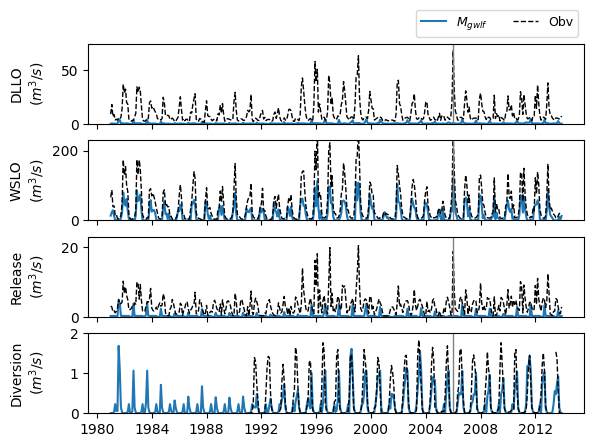

In [19]:
### Run a simulation.
model = hydrocnhs.Model(os.path.join(wd, "Cali_HydroABMModel_gwlf_KGE", "Best_HydroABMModel_gwlf_KGE.yaml"))
Q = model.run(temp, prec, pet)
sim_Q_D = pd.DataFrame(Q, index=model.pd_date_index)[["WSLO","DLLO"]]
sim_Q_D["ResAgt"] = model.dc.ResAgt["Release"]
sim_Q_D["DivAgt"] = model.dc.DivAgt["Diversion"]
sim_Q_M = sim_Q_D[["WSLO","DLLO","ResAgt","DivAgt"]].resample("MS").mean()
### Plot
fig, axes = plt.subplots(nrows=4, sharex=True)
axes = axes.flatten()
x = sim_Q_M.index
axes[0].plot(x, sim_Q_M["DLLO"], label="$M_{gwlf}$")
axes[1].plot(x, sim_Q_M["WSLO"], label="$M_{gwlf}$")
axes[2].plot(x, sim_Q_M["ResAgt"], label="$M_{gwlf}$")
axes[3].plot(x, sim_Q_M["DivAgt"], label="$M_{gwlf}$")

axes[0].plot(x, obv_flow_data["DLLO"], ls="--", lw=1, color="black", label="Obv")
axes[1].plot(x, obv_flow_data["WSLO"], ls="--", lw=1, color="black", label="Obv")
axes[2].plot(x, obv_flow_data["ResAgt"], ls="--", lw=1, color="black", label="Obv")
axes[3].plot(x, obv_flow_data["DivAgt"], ls="--", lw=1, color="black", label="Obv")

axes[0].set_ylim([0,75])
axes[1].set_ylim([0,230])
axes[2].set_ylim([0,23])
axes[3].set_ylim([0,2])

axes[0].set_ylabel("DLLO\n($m^3/s$)")
axes[1].set_ylabel("WSLO\n($m^3/s$)")
axes[2].set_ylabel("Release\n($m^3/s$)")
axes[3].set_ylabel("Diversion\n($m^3/s$)")

axes[0].axvline(pd.to_datetime("2006-1-1"), color="grey", ls="-", lw=1)
axes[1].axvline(pd.to_datetime("2006-1-1"), color="grey", ls="-", lw=1)
axes[2].axvline(pd.to_datetime("2006-1-1"), color="grey", ls="-", lw=1)
axes[3].axvline(pd.to_datetime("2006-1-1"), color="grey", ls="-", lw=1)

axes[0].legend(ncol=3, bbox_to_anchor=(1, 1.5), fontsize=9)

fig.align_ylabels(axes)